# EDA for IDA 2016 (Part 2)

In [1]:
######----- Importing dependencies-----#####
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

from sklearn.preprocessing import StandardScaler


np.random.seed(0)

In [2]:
######----- Setting Working directory-----#####
print(os.getcwd())
os.chdir(r"C:\Users\inabpan4\Desktop\work\Algos\Applied AI\I python notebook\self case study 1\to_uci")
print(os.getcwd())

C:\Users\inabpan4\Desktop\work\Algos\Applied AI\I python notebook\self case study 1\Code\final\01 aug
C:\Users\inabpan4\Desktop\work\Algos\Applied AI\I python notebook\self case study 1\to_uci


In [3]:
train_df = pd.read_csv(r".\aps_failure_training_set.csv", skiprows= 20, na_values='na')
test_df = pd.read_csv(r".\aps_failure_test_set.csv", skiprows= 20, na_values='na')
print("Shape of training dataset is", train_df.shape)
print("Shape of test dataset is", test_df.shape)

Shape of training dataset is (60000, 171)
Shape of test dataset is (16000, 171)


In [4]:
#####-----Storing imputed file-----#####
train_preprocessed= pd.read_csv("train_data_added_features.csv", index_col=0)
test_preprocessed=  pd.read_csv("test_data_added_features.csv", index_col=0)

print("Shape of training dataset is", train_preprocessed.shape)
print("Shape of test dataset is", test_preprocessed.shape)

Shape of training dataset is (60000, 172)
Shape of test dataset is (16000, 172)


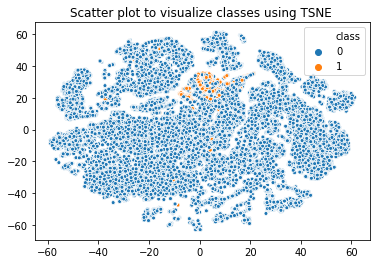

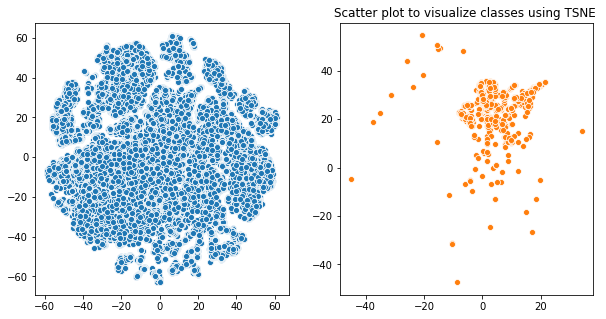

In [6]:
#####-----Scatter plot to visualize Data using TSNE ----#####
from sklearn.manifold import TSNE
data_for_plot = train_preprocessed.sample(5000)
data_for_plot_x = train_preprocessed.drop("class", axis = 1).copy()
data_for_plot_y = train_preprocessed["class"].copy()

train_preprocessed_embedded = TSNE(n_components=2, perplexity=50).fit_transform(data_for_plot_x)

sns.scatterplot(train_preprocessed_embedded[:,0],train_preprocessed_embedded[:,1],
                hue = data_for_plot_y, s = 15)
plt.title("Scatter plot to visualize classes using TSNE ")
plt.show()

fig, axes = plt.subplots(1, 2, figsize = (10,5))
sns.scatterplot(train_preprocessed_embedded[data_for_plot_y.values==0,0],
                train_preprocessed_embedded[data_for_plot_y.values==0,1],
                ax = axes[0],
                color = "C0"
               )
sns.scatterplot(train_preprocessed_embedded[data_for_plot_y.values==1,0],
                train_preprocessed_embedded[data_for_plot_y.values==1,1],
                ax = axes[1],
                color ="C1"
               )
plt.title("Scatter plot to visualize classes using TSNE ")
plt.show()

## 1. Outlier removal before imbalance handling

    Outliers in minority class will impact ADASYN algorithm as ADASYN gives more importance to points which are close to points belonging to other class. This is the reason why ADASYN will introduce more points around outliers, which will cause poor model performance. Therefore in below section outliers from minority classes will be removed from the data

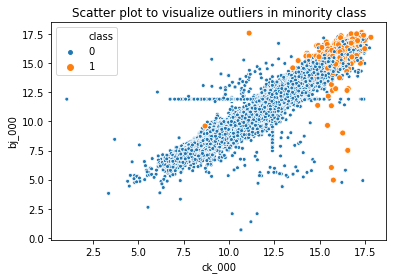

In [33]:
#####-----Scatter plot to visualize outliers in minority class ----#####

features= ['ck_000', 'bj_000'] # selcted features for scatter plot

sns.scatterplot(np.log(train_preprocessed.loc[train_preprocessed[features[0]] >0 ,
                                             features[0] ]), 
                np.log(train_preprocessed.loc[train_preprocessed[features[1]] >0 ,
                                             features[1] ]),
                hue = train_preprocessed["class"], 
                size=train_preprocessed["class"],
                sizes =[15,35])
plt.title("Scatter plot to visualize outliers in minority class")
plt.show()

    From the plot we can observe there are outliers in minority class which are located deep inside  majority class. As said earlier such points will get higher importance during oversampling using ADASYN method.
    Secondly these outliers will impact the model performance as well. Therefore these outliers will be dropped from minority class. 

### 1.1 Outlier detection using LOF 

In [207]:
pos_train_preprocessed = train_preprocessed[train_preprocessed["class"] == 1].copy()
neg_train_preprocessed = train_preprocessed[train_preprocessed["class"] == 0].copy()

from sklearn.neighbors import LocalOutlierFactor

LOF = LocalOutlierFactor(n_neighbors=20, n_jobs=4)
y_pred = LOF.fit_predict(pos_train_preprocessed)
label = np.where(y_pred==1, "inlier", "outlier")

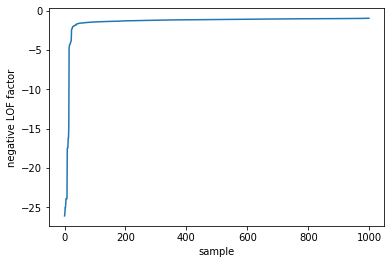

number of total_outliers are  71


In [239]:
X_scores = LOF.negative_outlier_factor_
plt.plot(np.sort(X_scores))
plt.xlabel("sample")
plt.ylabel("negative LOF factor")
plt.show()
print("number of total_outliers are ", (label == "outlier").sum())

#### 1.1.1  Outlier visualization using TSNE

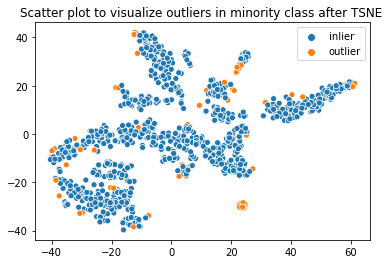

In [210]:
#####-----Scatter plot to visualize oulier in entire dat ausing TSNE ----#####
from sklearn.manifold import TSNE
pos_train_preprocessed_embedded = TSNE(n_components=2, perplexity=30).fit_transform(pos_train_preprocessed)

sns.scatterplot(pos_train_preprocessed_embedded[:,0],pos_train_preprocessed_embedded[:,1],
                hue = label, 
)
plt.title("Scatter plot to visualize outliers in minority class after TSNE ")
plt.show()

In [211]:
#####----- Outliers from positive class are removedand  concatenated with negative class data-----#####
pos_train_preprocessed_inlier = pos_train_preprocessed[label == "inlier"].copy()
pos_train_preprocessed_outlier = pos_train_preprocessed[label == "outlier"].copy()

train_data_preprocessed_no_outlier = pd.concat([neg_train_preprocessed, 
                                                pos_train_preprocessed_inlier]).sort_index()

In [212]:
train_data_preprocessed_no_outlier.shape

(59929, 172)

## 2. Handling Imbalance

In [243]:
from imblearn.over_sampling import ADASYN

## Spliting data into x and Y
x_train = train_data_preprocessed_no_outlier.drop("class", axis = 1, inplace= False)
train_class_label= train_data_preprocessed_no_outlier["class"].copy()

## Initializing ADASYN object and training it on x and Y DATA
ada = ADASYN(sampling_strategy= {0:59000, 1:25000}, random_state=0, n_neighbors=5, n_jobs=4)
x_train_res, train_class_label_res = ada.fit_resample(x_train, train_class_label)

train_preprocessed_res = pd.concat([x_train_res, train_class_label_res], axis= 1)
train_preprocessed_res.shape

(84048, 172)

    In the below section Count plot for target variable has been plotted in figure 1. Similarly scatter plot between two features 'ck_000' and 'bj_000' has been shown in figure 2 with colour coded according to target variable. From these plots  impact of over sampling can be analysed. 

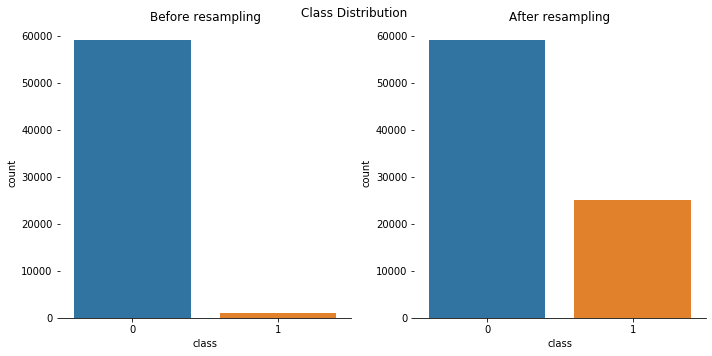

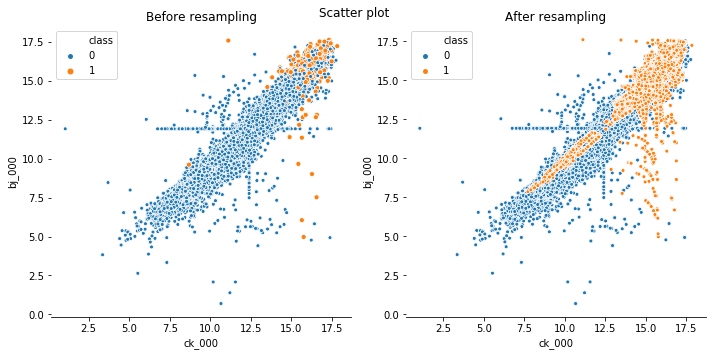

In [244]:
#####-----Countplot of target variable to visualize impact of oversampling ----#####
fig, axes = plt.subplots(1, 2, figsize = (10,5))
sns.despine(left=True)

sns.countplot(train_preprocessed["class"], ax= axes[0])
axes[0].set_title("Before resampling")

sns.countplot(train_preprocessed_res["class"] , ax= axes[1])
axes[1].set_title("After resampling")

fig.suptitle("Class Distribution ")
plt.tight_layout()
plt.show()



#####-----Scatter plot to visualize impact of oversampling ----#####

fig, axes = plt.subplots(1, 2, figsize = (10,5))
sns.despine(left=True)
features= ['ck_000', 'bj_000'] # selcted features for scatter plot

sns.scatterplot(np.log(train_preprocessed.loc[train_preprocessed[features[0]] >0 ,
                                             features[0] ]), 
                np.log(train_preprocessed.loc[train_preprocessed[features[1]] >0 ,
                                             features[1] ]),
                hue = train_preprocessed["class"], 
                size=train_preprocessed["class"],
                sizes =[15,25],
                ax= axes[0])
axes[0].set_title("Before resampling")

sns.scatterplot(np.log(train_preprocessed_res.loc[train_preprocessed_res[features[0]] >0 ,
                                             features[0] ]), 
                np.log(train_preprocessed_res.loc[train_preprocessed_res[features[1]] >0 ,
                                             features[1] ]),
                hue = train_preprocessed_res["class"], 
                size=train_preprocessed_res["class"],
                sizes =[15,15],
                ax= axes[1])
axes[1].set_title("After resampling")

fig.suptitle("Scatter plot ")
plt.legend()
plt.tight_layout()
plt.show()




    From these plots we can observe that the count of minority class has increased and now the ratio between majority and minority class is 2:1. From the scatter plot it is apparent that more points were added in the region where there were minority classes close to majority classes compared to dance region of minority classes(top right corner of the plot).  

## 1. Feature selection

### 1.1 VIF (To remove features with multicollinearity)
https://www.statisticshowto.com/variance-inflation-factor/

    VIF score provides a quantification for inflation in variance of a feature due to multicollinearity. Unlike correlation coefficients VIF considers all features to evaluate VIF score. VIF score of 1 indicate not multicollinearity whereas 1 to 5 is moderate collinearity. VIF score of more than 10 indicates severe multicollinearity.
    
    In the following section an analysis on VIF scores for all features have been shown through a plot of log of VIF in increase order and quantile values. These help us visualize how much multicollinearity is there in the dataset


In [231]:
#####----- Function to evaluated VIF scare for all features with no missing value-----#####
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [232]:
vif_df = calc_vif(train_preprocessed_res.sample(10000))

10 th quatile feature-wise fraction of VIF  2.285942842534039 and Log VIF is  0.8267505230098603
20 th quatile feature-wise fraction of VIF  4.93922031693113 and Log VIF is  1.5967147435441627
30 th quatile feature-wise fraction of VIF  10.606218992734652 and Log VIF is  2.3600664920711694
40 th quatile feature-wise fraction of VIF  91.00203053489692 and Log VIF is  4.434074554620091
50 th quatile feature-wise fraction of VIF  710.618005607987 and Log VIF is  6.565842772492774
60 th quatile feature-wise fraction of VIF  1311672.3785293412 and Log VIF is  14.043590251367574
70 th quatile feature-wise fraction of VIF  454973096.2677739 and Log VIF is  19.93568625827711
80 th quatile feature-wise fraction of VIF  6503399452.447685 and Log VIF is  22.59536158351852
90 th quatile feature-wise fraction of VIF  130342741843.36574 and Log VIF is  25.58687892254887
100 th quatile feature-wise fraction of VIF  750599937895082.6 and Log VIF is  34.2518939198891


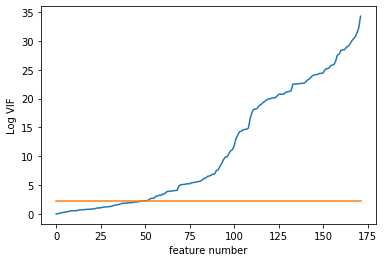

In [233]:
VIF_threshold  = 10 ## extreme multicolinearity
for q in np.arange(0.1,1.1,0.1):
    print(int(q*100), "th quatile feature-wise fraction of VIF ", 
          vif_df["VIF"].quantile(q), "and Log VIF is " , np.log(vif_df["VIF"]).quantile(q))
    
plt.plot(np.log(vif_df["VIF"].sort_values(ascending= True).values))
plt.plot([np.log(VIF_threshold)]*vif_df.shape[0])
plt.ylabel("Log VIF")
plt.xlabel("feature number")
plt.show()


    From the plots we can see there are variables/features with high VIF scores which indicates that there are multicollinearity among variables. 
    In the below section a recursive function for feature removal has been written. the function eliminates one feature at a time till maximum VIF score is < 10 


### 1.2 Recursive feature removal using VIF score

In [234]:
def feature_selection_VIF(X, VIF_threshold = 10):
    vif_df = calc_vif(X)
    max_vif_score = vif_df["VIF"].values.max()
    print("number of features are ", X.shape[1], "and maximum VIF score is ", max_vif_score)
    
    if (max_vif_score > VIF_threshold) :
        features_subset = vif_df.loc[vif_df["VIF"] < max_vif_score, "variables"].values
        vif_df =  feature_selection_VIF(X[features_subset], VIF_threshold)
        return(vif_df)
    else:
        return(vif_df)
    
    
    
vif_df = feature_selection_VIF(train_preprocessed_res.drop("class",axis=1, inplace =False).sample(20000, random_state =0) ,10) ## taking lesser sample for faster execution


number of features are  172 and maximum VIF score is  20706205183312.625
number of features are  171 and maximum VIF score is  603012603249.715
number of features are  169 and maximum VIF score is  14091208723.842186
number of features are  168 and maximum VIF score is  1738495869.4971833
number of features are  167 and maximum VIF score is  3004320.755330339
number of features are  166 and maximum VIF score is  617527.4835185041
number of features are  165 and maximum VIF score is  82583.66808055557
number of features are  164 and maximum VIF score is  44161.380451169076
number of features are  163 and maximum VIF score is  17490.809534881384
number of features are  162 and maximum VIF score is  4100.86518916322
number of features are  161 and maximum VIF score is  2412.6181888664373
number of features are  160 and maximum VIF score is  2135.893269562142
number of features are  159 and maximum VIF score is  1286.2868693128296
number of features are  158 and maximum VIF score is  787.2

In [237]:
#####----- Selecting only uncorrelated features from processed train and test data for further analysis-----#####
uncorrelated_features = vif_df["variables"]

train_data_subset = train_preprocessed_res[uncorrelated_features]
test_data_subset = test_preprocessed[uncorrelated_features]

## 2. Selecting top 2 important features for visualization 
    In the below section top two important features are selected using Mutual information concept. class wise density plot for these 2 features will be shown to identify if a classification logic can eb deduced from top 2 features 


In [249]:
# import the required functions and object.
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

# select the number of features you want to retain.
select_k = 2

x_train = train_data_subset.drop("class", axis = 1, inplace = False)
y_train = train_data_subset["class"]
# mi = mutual_info_classif(x_train, y_train)
selection = SelectKBest(mutual_info_classif, k=select_k).fit(x_train, y_train)
score_df = pd.DataFrame({"score": selection.scores_,
              "variable" : x_train.columns
             }).sort_values("score", ascending = False)
top_features = score_df["variable"].head(2).values
print(top_features)

['co_000' 'ad_000']


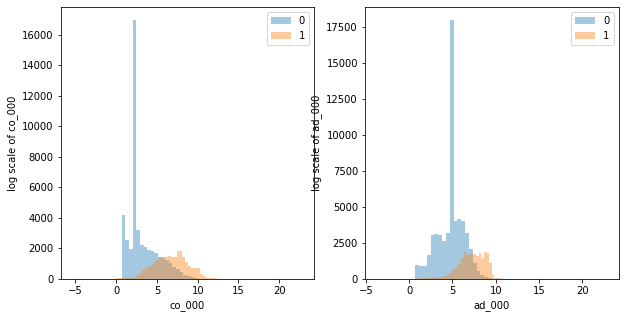

In [309]:
#####----- Displot ----####
fig, axes = plt.subplots(1, 2, figsize = (10,5))
for idx, feature in enumerate(top_features):
#     feature ="ck_000"
    sns.distplot(np.log(train_data_subset.loc[(train_data_subset["class" ]== 0) & (train_data_subset[feature] > 0),
                                              feature] ), label =0, kde= False,  ax= axes[idx]) 
    sns.distplot(np.log(train_data_subset.loc[(train_data_subset["class" ]== 1) & (train_data_subset[feature] > 0),
                                              feature] ), label = 1, kde= False,ax = axes[idx]) 
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel("log scale of "+feature)
    axes[idx].legend()
plt.show()



    From above figures we can observe that there is a shit in distribution of top 2 features for class 0 and 1.However there is overlap in the histogram.

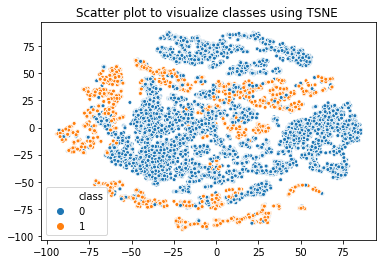

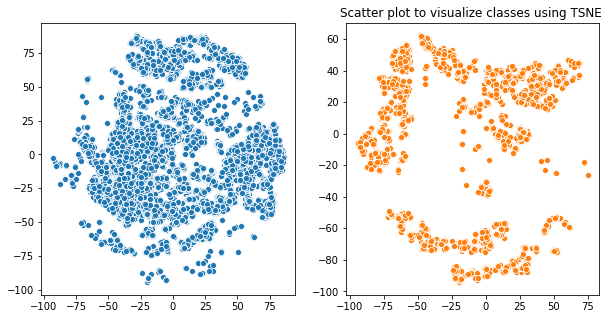

In [312]:
#####-----Scatter plot to visualize Data using TSNE ----#####
from sklearn.manifold import TSNE
data_for_plot = train_data_subset.sample(20000)
data_for_plot_x = data_for_plot.drop("class", axis = 1).copy()
data_for_plot_y = data_for_plot["class"].copy()

train_data_subset_embedded = TSNE(n_components=2, perplexity=30).fit_transform(data_for_plot_x)

sns.scatterplot(train_data_subset_embedded[:,0],train_data_subset_embedded[:,1],
                hue = data_for_plot_y, s = 15)
plt.title("Scatter plot to visualize classes using TSNE ")
plt.show()

fig, axes = plt.subplots(1, 2, figsize = (10,5))
sns.scatterplot(train_data_subset_embedded[data_for_plot_y.values==0,0],
                train_data_subset_embedded[data_for_plot_y.values==0,1],
                ax = axes[0],
                color = "C0"
               )
sns.scatterplot(train_data_subset_embedded[data_for_plot_y.values==1,0],
                train_data_subset_embedded[data_for_plot_y.values==1,1],
                ax = axes[1],
                color ="C1"
               )
plt.title("Scatter plot to visualize classes using TSNE ")
plt.show()

    There are regions where density of minority classes are more than Majority class. There are also regions where both classes are of equal probability . 
    

In [ ]:
#####-----Storing uncorrelated data file-----#####
train_data_subset.to_csv("train_data_uncorrelated.csv")
test_data_subset.to_csv("test_data_uncorrelated.csv")

## 3. Conclusions from EDA ( Part2) 

    1. There are outliers in minority(positive) class. These outliers will affect oversampling method and hence LOF based outlier method was used to remove them.71 samples out of 1000 samples were identified as outliers by the algorithm and were removed from training set.
    2. In order to handle imbalance oversampling of minority class from 1000 to 20000 has been performed using ADASYN algorithm. This resulted in a class ratio of 2:1 between majority and minority class. From the scatter plot it is apparent that more points were added in the region where there were minority classes close to majority classes compared to dance region of minority classes(top right corner of the plot).  
    3. Out of total of 171 features 104 features were found to be uncorrelated using recursive feature removal method based on VIF score.
    4. Mutual information based top 2 important features were selected and class wise distribution of each =feature was plotted. From the plot it was apparent that though  class wise distributions of features are different there are some overlapping among themselves.
    5. Class wise scatter plot using TSNE indicated that there are regions with more minority class example than majority class. However, in all area there are overlapping
